## Session Log Feature Engineering

### Description

First-time Airbnb users can book a stay in over 34,000+ cities across 190+ countries. To provide more personalized user recommendations, it is import to forecast the destination a user might choose for their first booking. In response to a <a href="https://www.kaggle.com/competitions/airbnb-recruiting-new-user-bookings">Kaggle challenge hosted by Airbnb</a>, the purpose of this project is to classify the destination country of a user's first booking. Destinations include 10 possible countries spanning across North America, Europe, and Australia, some other country beyond these, or no booking at all.

### Approach

The purpose of this script is to engineer user-level features by aggregating session-level data found in Airbnb session logs (<b>"sessions.csv"</b>). These features will be merged with the user-level features found in <b>"train_users_2.csv"</b> to predict the destination that first-time users booked on Airbnb. For the full machine learning workflow, see <b>"Airbnb New User First Booking Classification.ipynb."</b>

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

### Defining Functions

In [2]:
def cat_uni_viz(data: pd.DataFrame, features, cols: int = 1, cat_limit: int = 20,
                proportion: bool = True):
    rows = np.ceil(len(features) / cols).astype(int)
    
    fig = plt.figure(figsize=(cols*5, rows*4))
    axs = [fig.add_subplot(rows, cols, i+1) for i in range(len(features))]
    
    for feat, ax in zip(features, axs):
        cat_series = data[feat].value_counts(normalize=proportion)[:cat_limit]
        sns.barplot(x=cat_series.values, y=cat_series.index, ax=ax)
        ax.set_title(f"Top {cat_limit} Counts of {feat.title()}")
        
    plt.tight_layout()
        
        
def num_uni_viz(data: pd.DataFrame, features, cols: int = 3):
    rows = np.ceil(len(features) / cols).astype(int)
    
    fig = plt.figure(figsize=(cols*5, rows*4))
    axs = [fig.add_subplot(rows, cols, i+1) for i in range(len(features))]
    
    for feat, ax in zip(features, axs):
        sns.histplot(data=data, x=feat, ax=ax)
        ax.set_title(f"Histogram of {feat.title()}")
    
    plt.tight_layout()

### Importing and Examining Dataset

In [3]:
sessions = pd.read_csv("datasets/sessions.csv")

In [4]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10567737 entries, 0 to 10567736
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        object 
 1   action         object 
 2   action_type    object 
 3   action_detail  object 
 4   device_type    object 
 5   secs_elapsed   float64
dtypes: float64(1), object(5)
memory usage: 483.8+ MB


In [5]:
sessions.head(3)

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0


### Exploratory Data Analysis 

First, I will conduct exploratory data analysis on the sessions data in order to obtain a better understanding of the session-level features. This analysis will include examining missingness by feature, imputing missing values when appropriate, and examining the distributions of the categorical and numeric features.

##### Examining Missingness

Checking the proportion of missing values per feature.

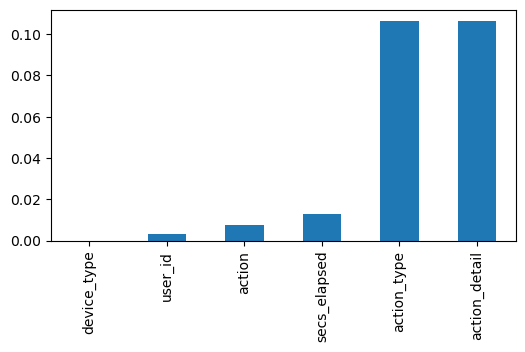

In [6]:
missingness_barplot = (sessions
                       .isna()
                       .mean()
                       .sort_values()
                       .plot(kind="bar", figsize=(6, 3)));

Given that this data will need to be merged on "user_id", any missing data for "user_id" should be filtered out.

In [7]:
missing_user_id = sessions["user_id"].isna()

print(f"Number of observations before: {sessions.shape[0]}")

sessions = sessions[~missing_user_id].copy()

print(f"Number of observations after: {sessions.shape[0]}")

Number of observations before: 10567737
Number of observations after: 10533241


The highest proportion of missing data is for the "action_type" and "action_detail" features. It is unclear whether missingness on one feature is related to the other.

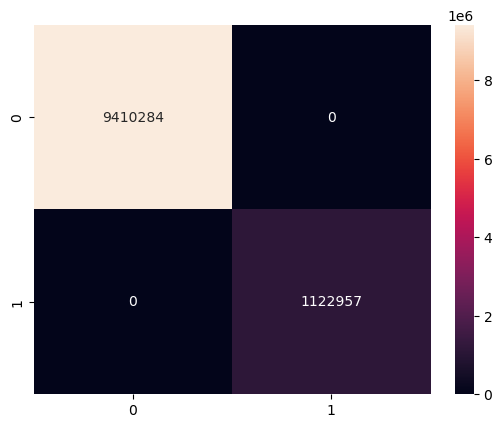

In [8]:
missing_cmat = confusion_matrix(sessions["action_type"].isna().astype(int),
                                sessions["action_detail"].isna().astype(int))

sns.heatmap(missing_cmat, annot=True, fmt="d");

There is a one-to-one correspondence. When "action_type" is missing so is "action_detail".

##### Feature Imputation

For the categorical features, I will impute a "missing" category because the fact that the data is missing may be relevant for the purposes of classification.

Distinguishing between categorical and numeric features.

In [9]:
categorical_features = (sessions
                        .drop("user_id", axis=1)
                        .select_dtypes("object")
                        .columns.tolist())

numeric_features = (sessions
                    .drop("user_id", axis=1)
                    .select_dtypes("number")
                    .columns.tolist())

print(f"Categorical features are: {categorical_features}",
      f"Numeric features are: {numeric_features}",
      sep="\n")

Categorical features are: ['action', 'action_type', 'action_detail', 'device_type']
Numeric features are: ['secs_elapsed']


Imputing "missing" category for missing values for categorical features.

In [10]:
si = SimpleImputer(strategy="constant", fill_value="missing")

sessions[categorical_features] = si.fit_transform(sessions[categorical_features])

sessions.isna().sum()

user_id               0
action                0
action_type           0
action_detail         0
device_type           0
secs_elapsed     135483
dtype: int64

I will not impute data for the continuous "secs_elapsed" feature, because any such imputation may distort the mean, standard deviation, and skew of the feature when aggregated at the user-level.

##### Examining Distribution of Categorical Features

Examining the number of unique categories for each categorical feature.

In [11]:
sessions[categorical_features].nunique()

action           360
action_type       11
action_detail    156
device_type       14
dtype: int64

Given that the "action" and "action_detail" features include many different categorical values, I will examine how many different values make up at least 1% of the dataset.

In [12]:
for col in ["action", "action_detail"]:
    values_1per = sessions[col].value_counts(normalize=True) >= .01
    print(f"{values_1per.sum()} values at least 1% of {col}.")

18 values at least 1% of action.
16 values at least 1% of action_detail.


Visualizing up to the top 20 most frequent categories of each categorical feature.

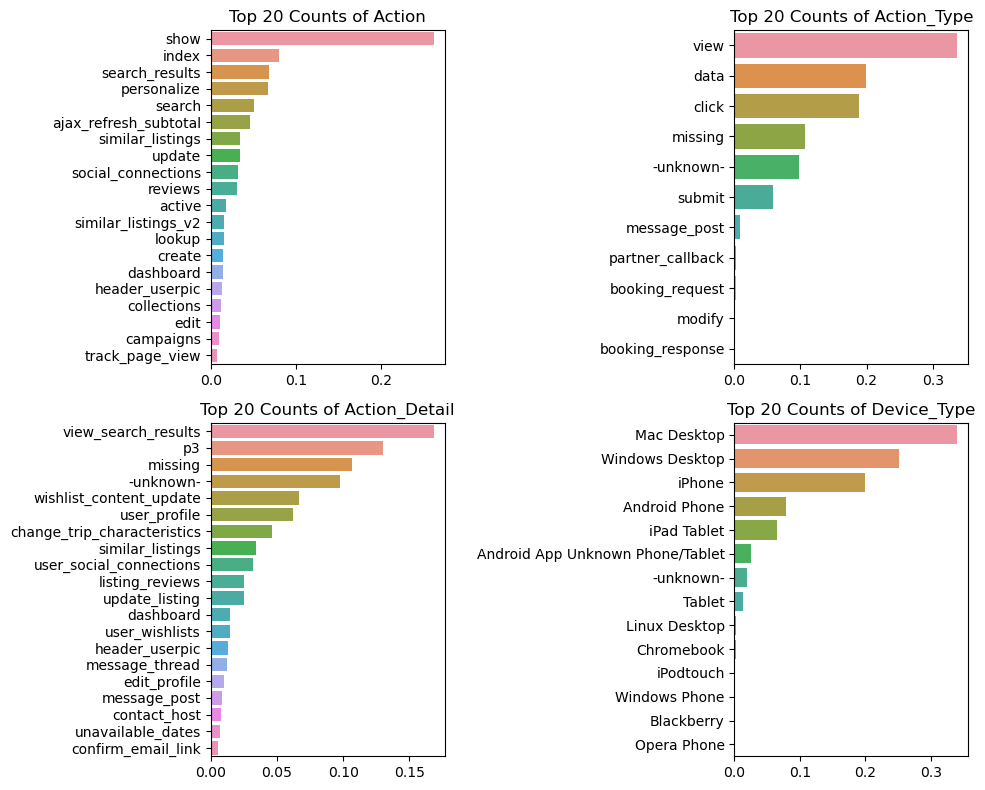

In [13]:
cat_uni_viz(data=sessions, features=categorical_features, cat_limit=20, cols=2)

In terms of feature engineering, I will calculate the number of unique action, action type, action detail, and device type values per user. 

In addition, I will sum the number of times each user showed each action, action type, action detail, and device type value, with the caveat that any feature value that comprises less than 1% of a given feature will be encoded as an infrequent category for that feature.

##### Examining Distribution of Numeric Feature

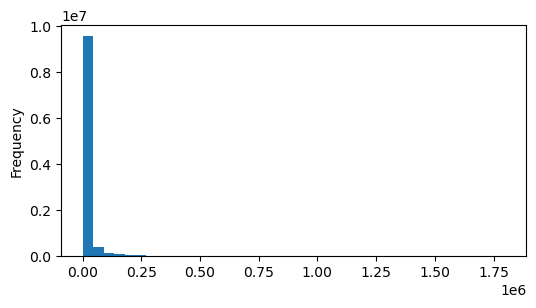

In [15]:
sessions["secs_elapsed"].plot(kind="hist", bins=40, figsize=(6, 3));

As might be expected, seconds elapsed is highly positively skewed. 

In terms of feature engineering, I will calculate the mean, standard deviation, and skew in "secs_elapsed" as user-level features. 

### Engineering Aggregated Features by Users

First, I will obtain and visualize the number of session events per user.

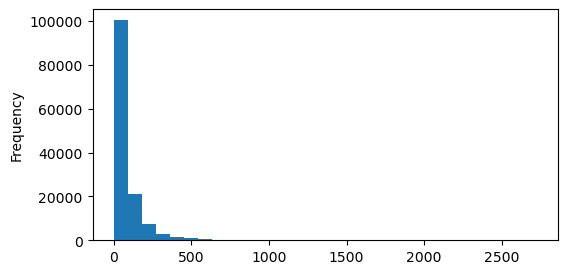

In [16]:
actions_by_user = pd.Series(sessions.groupby("user_id").size(), name="action_num")

actions_by_user.plot(kind="hist", bins=30, figsize=(6, 3));

Next, I will obtain the number of unique actions, action details, action types, and device types for each user.

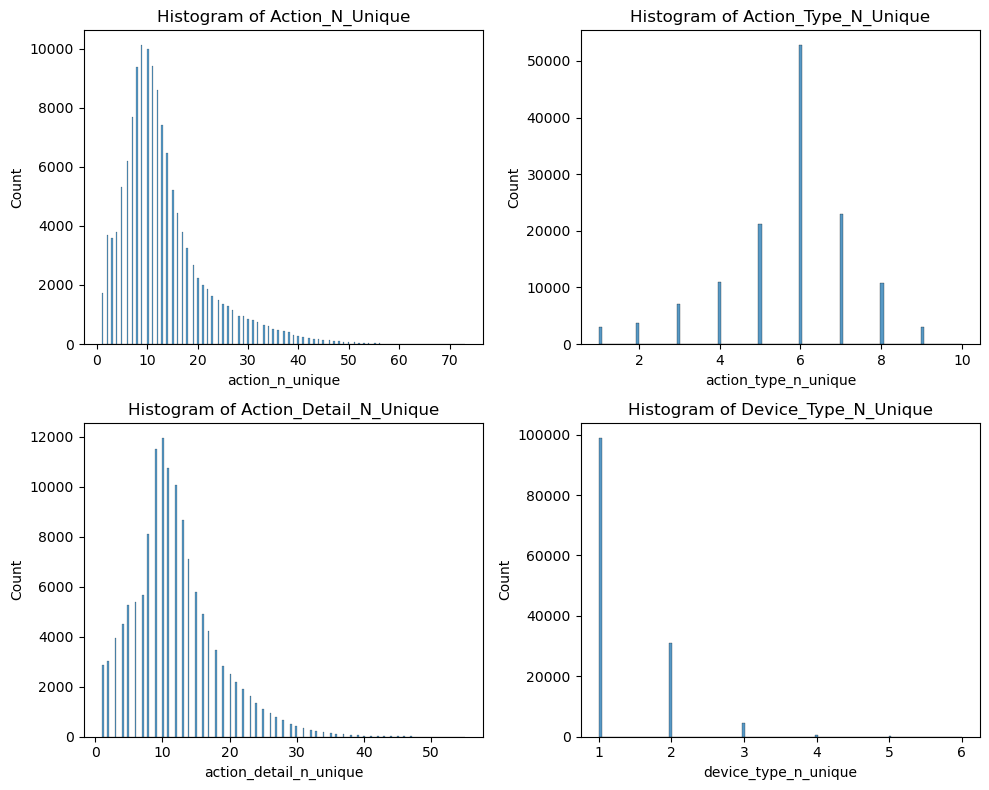

In [17]:
unique_cat_labels = [feat + "_n_unique" for feat in categorical_features]

unique_cats_by_user = (sessions
                       .groupby("user_id")[categorical_features]
                       .apply(lambda x: x.nunique())
                       .set_axis(unique_cat_labels, axis=1))

num_uni_viz(data=unique_cats_by_user,
            features=unique_cats_by_user.columns.tolist(),
            cols=2)

In addition, I will get counts for any action value, action detail value, action type value, or device type value representing more than 1% of values using one hot encoding. Any values that comprise less than 1% of the feature will be encoded in a single infrequent category. 

In [18]:
ohe = OneHotEncoder(sparse_output=False, min_frequency=.01).set_output(transform="pandas")

sessions_cat_ohe = ohe.fit_transform(sessions[categorical_features])

cats_by_user = sessions_cat_ohe.groupby(sessions["user_id"]).sum()

Examining descriptive statistics of resulting summed ohe columns.

In [19]:
with pd.option_context("display.max_columns", None):
    display(cats_by_user.describe().loc[["min", "25%", "50%", "75%", "max"]])

,action_active,action_ajax_refresh_subtotal,action_collections,action_create,action_dashboard,action_edit,action_header_userpic,action_index,action_lookup,action_personalize,action_reviews,action_search,action_search_results,action_show,action_similar_listings,action_similar_listings_v2,action_social_connections,action_update,action_infrequent_sklearn,action_type_-unknown-,action_type_click,action_type_data,action_type_missing,action_type_submit,action_type_view,action_type_infrequent_sklearn,action_detail_-unknown-,action_detail_change_trip_characteristics,action_detail_dashboard,action_detail_edit_profile,action_detail_header_userpic,action_detail_listing_reviews,action_detail_message_thread,action_detail_missing,action_detail_p3,action_detail_similar_listings,action_detail_update_listing,action_detail_user_profile,action_detail_user_social_connections,action_detail_user_wishlists,action_detail_view_search_results,action_detail_wishlist_content_update,action_detail_infrequent_sklearn,device_type_-unknown-,device_type_Android App Unknown Phone/Tablet,device_type_Android Phone,device_type_Mac Desktop,device_type_Tablet,device_type_Windows Desktop,device_type_iPad Tablet,device_type_iPhone,device_type_infrequent_sklearn
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,2.0,0.0,1.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,6.0,3.0,5.0,6.0,3.0,2.0,12.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,1.0,3.0,0.0,1.0,2.0,0.0,1.0,7.0,0.0,5.0,0.0,1.0,3.0,23.0,1.0,0.0,0.0,1.0,16.0,8.0,16.0,17.0,8.0,4.0,31.0,1.0,8.0,3.0,2.0,0.0,1.0,0.0,0.0,8.0,10.0,1.0,0.0,3.0,0.0,0.0,14.0,5.0,13.0,0.0,0.0,0.0,17.0,0.0,6.0,0.0,1.0,0.0
max,199.0,308.0,260.0,140.0,89.0,98.0,183.0,544.0,705.0,524.0,476.0,987.0,910.0,1593.0,325.0,343.0,352.0,339.0,2665.0,2632.0,987.0,861.0,806.0,341.0,1839.0,456.0,2632.0,308.0,89.0,98.0,183.0,242.0,320.0,806.0,1293.0,325.0,320.0,454.0,352.0,260.0,987.0,524.0,486.0,813.0,1548.0,2264.0,2705.0,2644.0,2335.0,1610.0,2473.0,695.0


For numeric features, I will obtain the mean, standard deviation, and skew of "secs_elapsed".

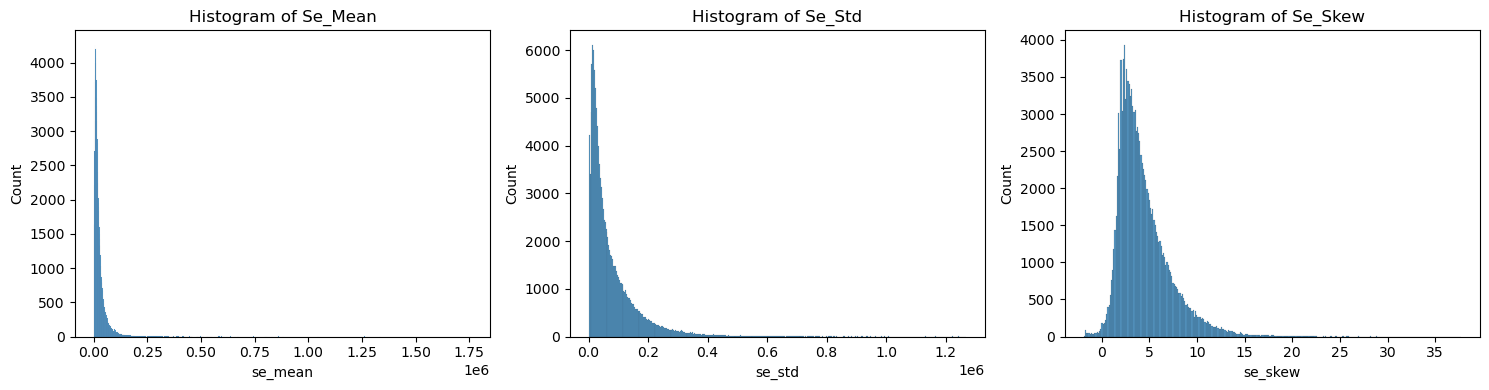

In [20]:
se_desc_by_user = (sessions
                   .groupby("user_id")["secs_elapsed"]
                   .agg(["mean", "std", "skew"])
                   .set_axis(["se_mean", "se_std", "se_skew"], axis=1))

num_uni_viz(data=se_desc_by_user, features=se_desc_by_user.columns.tolist(),  cols=3)

Merging all engineered features together in one dataframe.

In [21]:
aggregated_dfs = [actions_by_user, unique_cats_by_user, cats_by_user, se_desc_by_user]

aggregated_sessions_df = pd.concat(objs=aggregated_dfs, axis=1)

aggregated_sessions_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 135483 entries, 00023iyk9l to zzzlylp57e
Data columns (total 60 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   action_num                                    135483 non-null  int64  
 1   action_n_unique                               135483 non-null  int64  
 2   action_type_n_unique                          135483 non-null  int64  
 3   action_detail_n_unique                        135483 non-null  int64  
 4   device_type_n_unique                          135483 non-null  int64  
 5   action_active                                 135483 non-null  float64
 6   action_ajax_refresh_subtotal                  135483 non-null  float64
 7   action_collections                            135483 non-null  float64
 8   action_create                                 135483 non-null  float64
 9   action_dashboard                        

### Saving Dataframe as CSV file 

In [22]:
aggregated_sessions_df.to_csv("datasets/aggregated_sessions_data.csv")